In [142]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.fits as fits

def fft_pxscale(ima,wave):
    
    """Compute conversion scale from telescope space to sky space.
        
       Parameters
       ----------
       ima : array
           2D Telescope pupil model.
        
       Returns
       -------
       fftscale : float
           The frequency scale in sky space.
        
       Example
       -------
       .. code-block:: python
        
          fftscale = fft_pxscale(ima)
        
    """
    
    #size of the image. This should be taken from the header.
    gridsize = ima[0].header['NAXIS1']
    #pixel scale of the image. This should be taken from the header.
    pxscale_mod = ima[0].header['PIXSCALE']    #in meters
    #1D FFT of the gridsize.
    fft_freq=np.fft.fftfreq(gridsize,pxscale_mod)
    #wavelength of the desires psf. This is a input of the user, wavelength in microns
    lam = wave*1E-6                 #in meters
    #re-orginizing the 1D FFT to match with the grid.
    roll=np.floor(gridsize/2).astype("int")
    freq = np.fft.fftshift(fft_freq)
    ##
    ## pxscale -> fftscale
    fftscale=np.diff(freq)[0]           ## cycles / mas per pixel in FFT image
    mas2rad=np.deg2rad(1./3600000.)     ## mas per rad
    fftscale = fftscale/mas2rad * lam   ## meters baseline per px in FFT image at a given wavelength
    print "Pixel scale in PSF image is: ", fftscale, " mas per pixel"
    
    return fftscale

4.4316
7.65457
17.4242
23.427
24.7766
35.8556


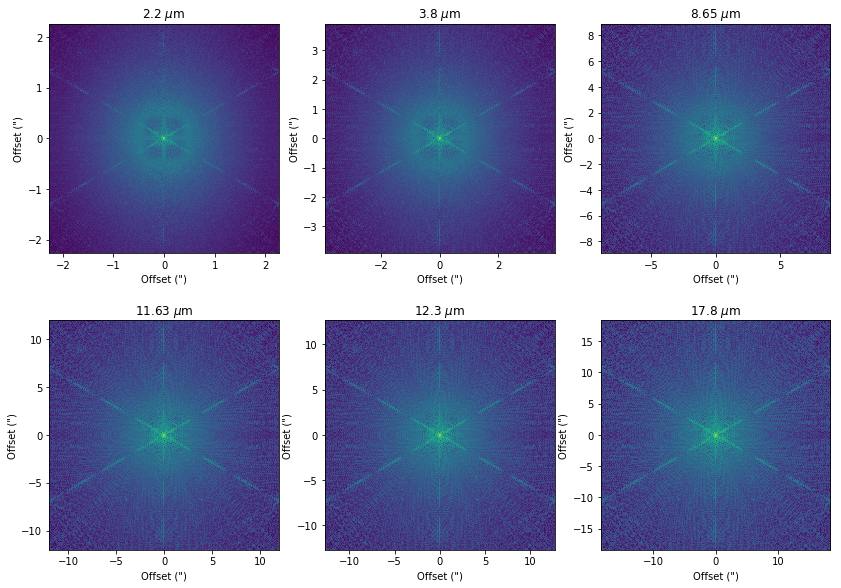

In [148]:
##E-ELT - METIS
#It’s a MEF, so note the axes, and you can see from the header the wavelength 
#and pixel scale (in mas) for each frame.

EELT_psf_file = '../psf/metis_psf_mag=03.00_seeing=0.80.fits' 

eelt_psf = fits.open(EELT_psf_file)

fig, axs = plt.subplots(2,3,figsize=(14,10))
ax = axs.flatten()

for ii in range(eelt_psf[0].header['NAXIS4']):
    wave    = eelt_psf[0].header[7+ii]
    pxscale = eelt_psf[0].header[13+ii]
    psf     = eelt_psf[0].data[ii][0]
    
    fov = eelt_psf[0].header['NAXIS1']*pxscale/2./1000.
    
    ax[ii].imshow(np.log10(psf),origin='lower',interpolation='Nearest', extent=[-fov,fov,-fov,fov])
    ax[ii].set_title(np.str(wave)+' $\\mu$m')
    ax[ii].set_xlabel('Offset (")')
    ax[ii].set_ylabel('Offset (")')
    
fig.savefig('E-ELT_METIS_psf.png',dpi=120)    

Pixel scale in PSF image is:  14.1807054295  mas per pixel
Pixel scale in PSF image is:  19.3373255857  mas per pixel
Pixel scale in PSF image is:  29.0059883785  mas per pixel
Pixel scale in PSF image is:  51.5662015618  mas per pixel
Pixel scale in PSF image is:  64.4577519522  mas per pixel


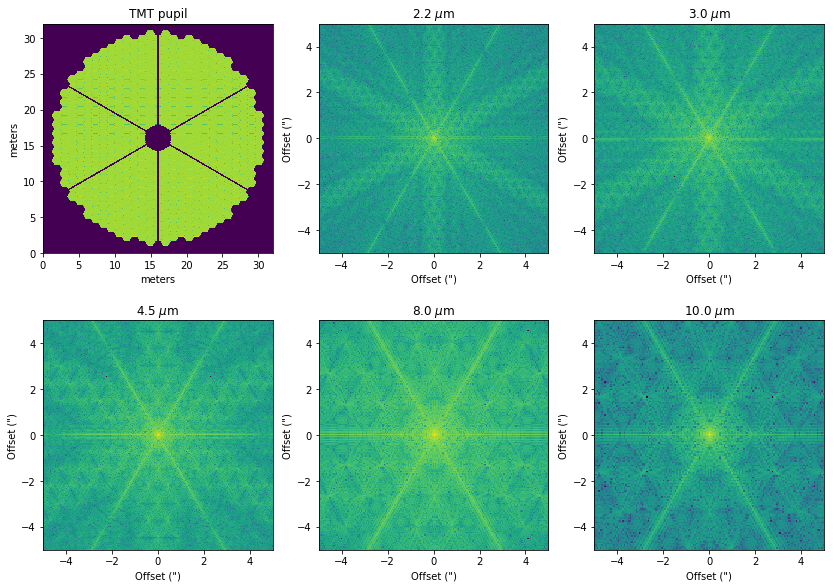

In [145]:
##TMT
#They had been simulating all sorts of things for the TMT, but *not* a perfect beam.  
#Instead they had loaded all the possible segment misalignments, surface roughness etc. 
#and so the request was too ‘simple’ for them.  
#Instead, what they have sent is is OPD map (optical path difference) and if we take 
#the Fourier transform of that map we should get the delivered image.  

TMT_pupil_file = '../psf/TMT_Pupil_Amplitude_Gray_Pixel_Approximated_With_Obscuration.fits'

TMT_pupil_fits = fits.open(TMT_pupil_file)


wave = np.array([2.2,3.0,4.5,8.0,10.0])


fig, axs = plt.subplots(2,3,figsize=(14,10))
ax = axs.flatten()

for ii in range(len(waves)+1):
    #TMT pupil
    fov = TMT_pupil_fits[0].header['NAXIS1']*TMT_pupil_fits[0].header['PIXSCALE'] #in meters
    ax[0].imshow(TMT_pupil,origin='lower',interpolation='Nearest',extent=[0,fov,0,fov])
    ax[0].set_title('TMT pupil')
    ax[0].set_xlabel('meters')
    ax[0].set_ylabel('meters')

    #TMT PSF
    if ii > 0:
        TMT_pupil = TMT_pupil_fits[0].data
        fov = fft_pxscale(TMT_pupil_fits,wave[ii-1]) #in arcsec
        TMT_psf = np.abs(np.fft.fftshift(np.fft.fft2(TMT_pupil)))/2*1000. #in arcsec
        
        fov_cut = 5 #in arcsec
        fov_px = np.int(fov_cut /(fov/1000.))  #in pixels
        xc = np.int(TMT_pupil_fits[0].header['NAXIS1']/2.)
        TMT_psf = TMT_psf[xc-fov_px:xc+fov_px,xc-fov_px:xc+fov_px]
        
        ax[ii].imshow(np.log10(TMT_psf),origin='lower',interpolation='Nearest',\
                      extent=[-fov_cut,fov_cut,-fov_cut,fov_cut])
        ax[ii].set_title(np.str(wave[ii-1])+' $\\mu$m')
        ax[ii].set_xlabel('Offset (")')
        ax[ii].set_ylabel('Offset (")')
        
fig.savefig('TMT_PSF.png')        